# ChatGPT-3 v Humans

Performing lexical-semantical analysis of chatGPT-3 and humans

In [1]:
# all imports 
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import re
import unicodedata
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


In [2]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# read dataset: stackoverflow v tedx
df = pd.read_csv('/content/drive/MyDrive/ChatGPTvHumans/stackoverflow_humanVchatgpt.csv')
# df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.tail()

,q_body,aa_body,chatgpt
86,What's the best way to implement BDD/TDD in .N...,We use MbUnit and Rihno Mocks and they prove t...,"For .NET 2.0, you can use the NUnit framework ..."
87,.htaccess directives to *not* redirect certain...,And the correct answer iiiiis...RewriteRule ...,You can try the following approach to exclude ...
88,What was the <XMP> tag used for? Does anyone r...,A quick Google search on W3C reveals that XMP ...,The <xmp> tag was a deprecated HTML tag that w...
89,How can I create Prototype Methods (like JavaS...,You can't dynamically add methods to existing ...,C# does not support prototype-based programmin...
90,SQL Case Expression Syntax? What is the comple...,The complete syntax depends on the database en...,The basic syntax for a SQL CASE expression is:...


In [5]:
# drop Prompt
df1 = df.drop('q_body', axis=1)
df_human = df1.drop('chatgpt', axis=1)
df_chatgpt = df1.drop('aa_body', axis=1)

In [6]:
df_human.head()

,aa_body
0,Cramer's RuleandGaussian Eliminationare two go...
1,"First: Yes, this is something that belongs in ..."
2,"A solution, albeit one that defers handling of..."
3,"If you expect infrequent collisions, Optimisti..."
4,"I've seen it done in a kind of iffy, but prett..."


In [7]:
df_chatgpt.head()

,chatgpt
0,To solve a system of linear equations programm...
1,"In Visual Studio 2003, it is not possible to a..."
2,To express a left join with an aggregate funct...
3,To express the SQL left join with an aggregate...
4,You can use the window.getComputedStyle method...


In [8]:
# change datatype to string
df_human['aa_body'] = df_human['aa_body'].fillna('').astype(str)
df_chatgpt['chatgpt'] = df_chatgpt['chatgpt'].fillna('').astype(str)

In [9]:
# remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words("english")

def remove_stopwords(text):
  filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
  return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# tested, works
df_human["aa_body"] = df_human.aa_body.map(remove_stopwords)
df_chatgpt["chatgpt"] = df_chatgpt.chatgpt.map(remove_stopwords)

In [11]:
def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

# Unigram model


In [12]:
# run the clean function
# words = basic_clean(''.join(str(df_noSW['Answer'].tolist())))
human_words = basic_clean(''.join(str(df_human['aa_body'].tolist())))
chatgpt_words = basic_clean(''.join(str(df_chatgpt['chatgpt'].tolist())))

## Visualizing 'human words'

In [13]:
unigram = (pd.Series(nltk.ngrams(human_words, 1)).value_counts())
bigram = (pd.Series(nltk.ngrams(human_words, 2)).value_counts())
trigram = (pd.Series(nltk.ngrams(human_words, 3)).value_counts())

In [14]:
# create series of top 10 of n-gram
unigrams_series = unigram[:10]
bigrams_series = bigram[:10]
trigrams_series = trigram[:10]

Text(0.5, 0, '# of Occurances')

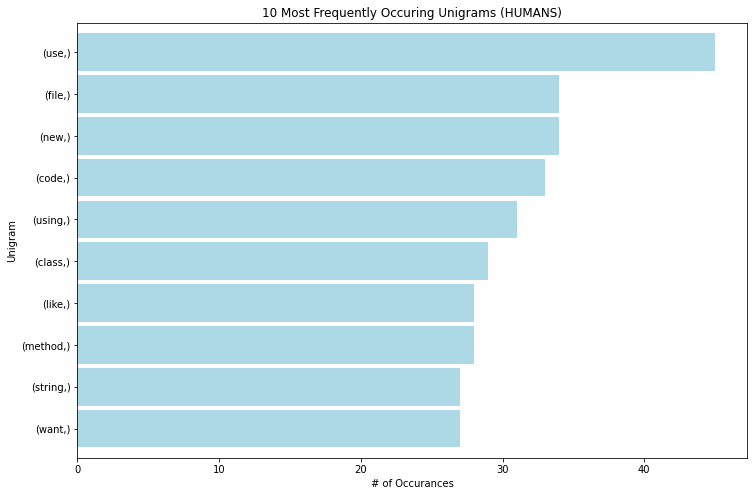

In [15]:
unigrams_series.sort_values().plot.barh(color='lightblue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Unigrams (HUMANS)')
plt.ylabel('Unigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

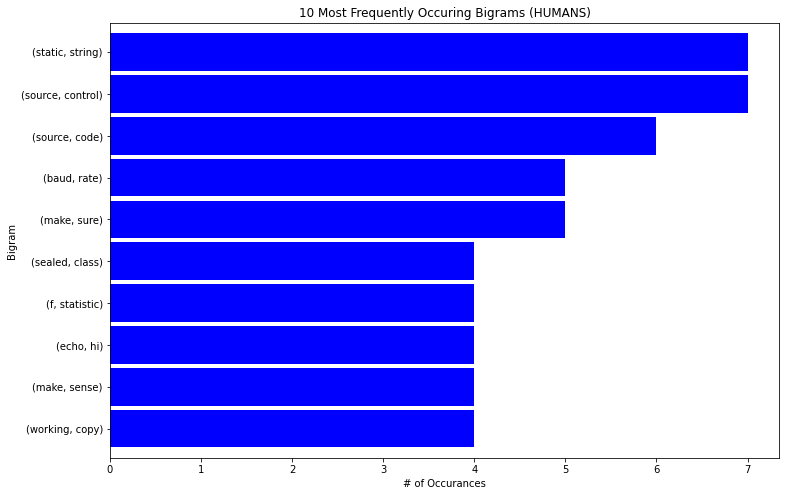

In [16]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams (HUMANS)')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

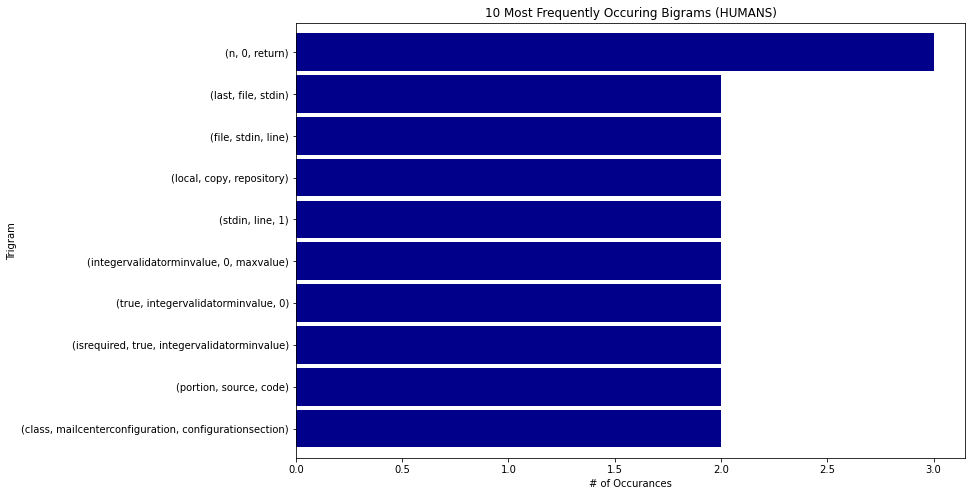

In [17]:
trigrams_series.sort_values().plot.barh(color='darkblue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams (HUMANS)')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

## Visualizing 'chatgpt words'

In [18]:
unigram = (pd.Series(nltk.ngrams(chatgpt_words, 1)).value_counts())
bigram = (pd.Series(nltk.ngrams(chatgpt_words, 2)).value_counts())
trigram = (pd.Series(nltk.ngrams(chatgpt_words, 3)).value_counts())

In [19]:
# create series of top 10 of n-gram
unigrams_series = unigram[:10]
bigrams_series = bigram[:10]
trigrams_series = trigram[:10]

Text(0.5, 0, '# of Occurances')

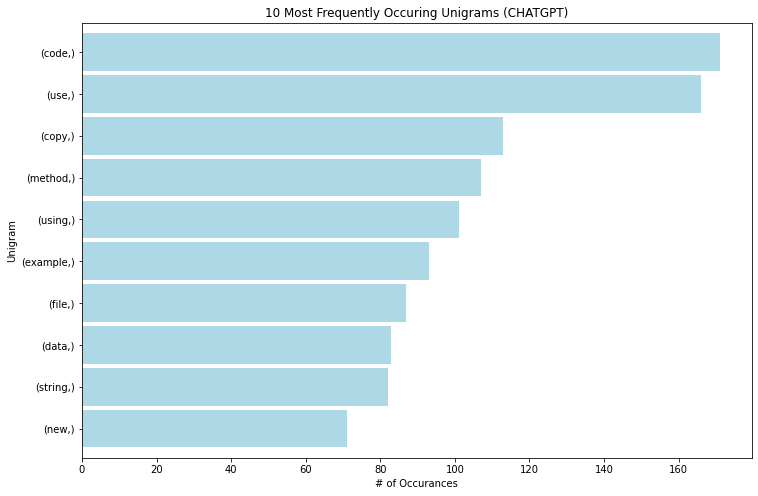

In [20]:
unigrams_series.sort_values().plot.barh(color='lightblue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Unigrams (CHATGPT)')
plt.ylabel('Unigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

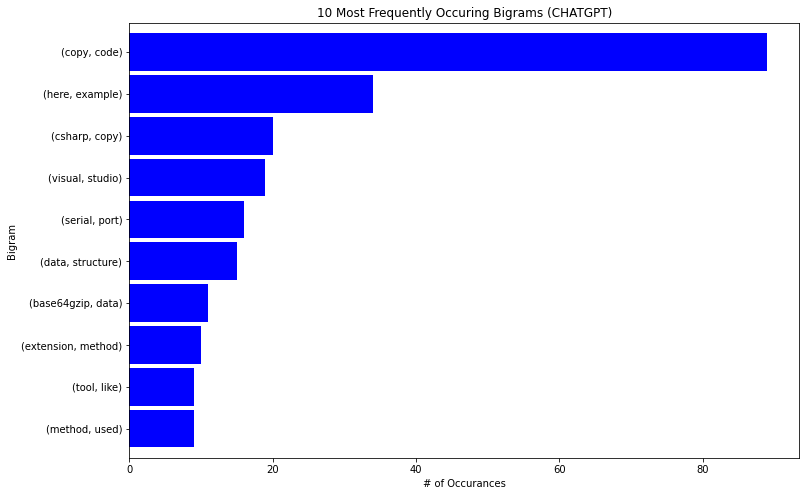

In [21]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams (CHATGPT)')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

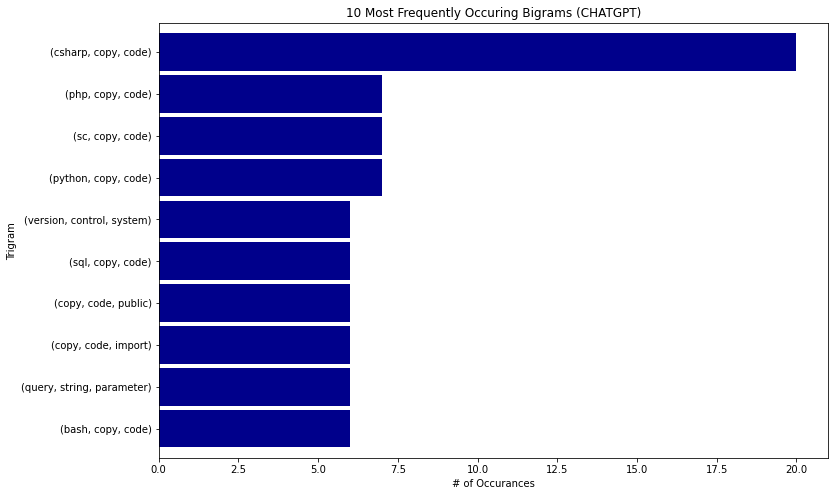

In [22]:
trigrams_series.sort_values().plot.barh(color='darkblue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams (CHATGPT)')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

# Average Text length

In [39]:
# human sentence length
text_column = df_human['aa_body']
sentences = text_column.apply(nltk.sent_tokenize)
sentence_lengths = sentences.apply(lambda x: [len(sent.split()) for sent in x])
df['sentence_lengths'] = sentence_lengths
average_sentence_length = np.mean([length for lengths in df['sentence_lengths'] for length in lengths])
variance_sentence_length = np.var([length for lengths in df['sentence_lengths'] for length in lengths])
print("average sentence length:", average_sentence_length)
print("variance in sentence length:",variance_sentence_length)

average sentence length: 16.971264367816094
variance in sentence length: 477.7060708151671


In [40]:
# chatgpt sentence length
text_column = df_chatgpt['chatgpt']
sentences = text_column.apply(nltk.sent_tokenize)
sentence_lengths = sentences.apply(lambda x: [len(sent.split()) for sent in x])
df['sentence_lengths'] = sentence_lengths
average_sentence_length = np.mean([length for lengths in df['sentence_lengths'] for length in lengths])
variance_sentence_length = np.var([length for lengths in df['sentence_lengths'] for length in lengths])
print("average sentence length:", average_sentence_length)
print("variance in sentence length:",variance_sentence_length)

average sentence length: 15.801369863013699
variance in sentence length: 369.0961625070369


## naive

In [25]:
text_column = df_human['aa_body']

# initialize variables to store the total number of words and the total number of sentences
total_words = 0
total_sentences = 0

# loop over each row in the text column
for text in text_column:
    # split the text into sentences using a simple rule-based approach
    sentences = text.split('. ')
    # count the number of sentences and add it to the total
    num_sentences = len(sentences)
    total_sentences += num_sentences
    # count the number of words in each sentence and add it to the total
    for sentence in sentences:
        words = sentence.split()
        num_words = len(words)
        total_words += num_words

# calculate the average sentence length by dividing the total number of words by the total number of sentences
average_sentence_length = total_words / total_sentences
print(average_sentence_length)

17.59880239520958


In [26]:
text_column = df_chatgpt['chatgpt']

# initialize variables to store the total number of words and the total number of sentences
total_words = 0
total_sentences = 0

# loop over each row in the text column
for text in text_column:
    # split the text into sentences using a simple rule-based approach
    sentences = text.split('. ')
    # count the number of sentences and add it to the total
    num_sentences = len(sentences)
    total_sentences += num_sentences
    # count the number of words in each sentence and add it to the total
    for sentence in sentences:
        words = sentence.split()
        num_words = len(words)
        total_words += num_words

# calculate the average sentence length by dividing the total number of words by the total number of sentences
average_sentence_length = total_words / total_sentences
print(average_sentence_length)

15.835164835164836


## Visualize sentence length

Text(0.5, 0, 'String')

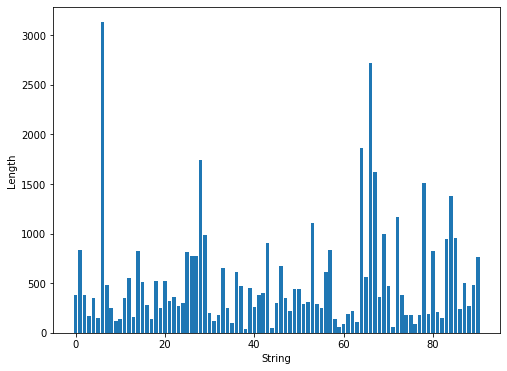

In [30]:
# create an array of strings
string_array = df_human['aa_body']

# calculate the length of each string in the array
string_lengths = [len(s) for s in string_array]

fig = plt.figure(figsize=(8, 6))
# plot a bar chart of the string lengths
plt.bar(range(len(string_lengths)), string_lengths)
# plt.xticks(range(len(string_lengths)), string_array)
plt.ylabel("Length")
plt.xlabel("String")

Text(0.5, 0, 'String')

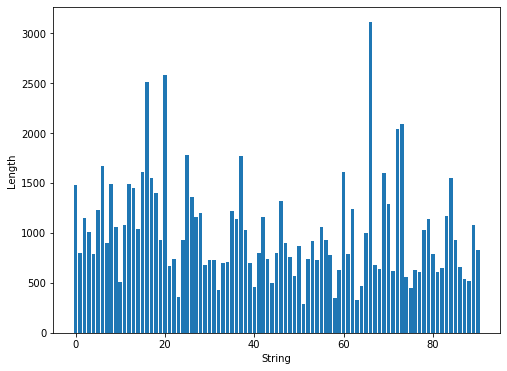

In [31]:
# create an array of strings
string_array = df_chatgpt['chatgpt']

# calculate the length of each string in the array
string_lengths = [len(s) for s in string_array]

fig = plt.figure(figsize=(8, 6))
# plot a bar chart of the string lengths
plt.bar(range(len(string_lengths)), string_lengths)
# plt.xticks(range(len(string_lengths)), string_array)
plt.ylabel("Length")
plt.xlabel("String")